In [79]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# Loan default factors analysis

by: Moiez Ismail

#### Table of Contents:
- [Introduction](#Introduction)
- [Data overview](#Data-overview)
- [Data cleaning and processing](#Data-cleaning-and-preprocessing)
- [Analysis](#Analysis)
- [Insights and conclusion](#Insights-and-conclusions)

# Introduction
A ficticious bank, Global Bank (GB) derives profit from interest on loans but faces risks when clients default on their loans (DL hereafter). Defaulting refers to when a loan is not properly paid off in full(GL hereafter), either with missed payments(delinquency) or no payments at all. The approval process is crucial to minimize DLs and maximize GLs.
## Objective
- GB is conducting a data analysis in order to gain insights in order to assist in the loan approval process. 
## Key Questions
- What factors or category of factors are most indicative of a client's likelihood to default? 
- Is there a statistically significant difference in certain numerica/categorical features between GL and DL? 
## Executive Summary
This analysis delves into the factors contributing to loan defaults at Global Bank (GB). Our exploration reveals critical insights into loan amounts, property values, credit history, employment, and loan reasons. Key findings suggest a significant correlation between loan defaults and factors such as the reasons for loans and credit history. These insights provide actionable recommendations for GB's loan approval process, aiming to minimize defaults and maximize successful repayments.

### Data dictionary
| Variable  | Data Type     | Description                                                                                               |
|-----------|---------------|-----------------------------------------------------------------------------------------------------------|
| BAD       | Binary (1/0)  | 1 = Client defaulted on loan, 0 = loan repaid                                                            |
| LOAN      | Numeric       | Amount of loan approved.                                                                                  |
| MORTDUE   | Numeric       | Amount due on the existing mortgage.                                                                      |
| VALUE     | Numeric       | Current value of the property.                                                                           |
| REASON    | Categorical   | Reason for the loan request. (HomeImp = home improvement, DebtCon = debt consolidation)                   |
| JOB       | Categorical   | The type of job that loan applicant has, such as manager, self, etc.                                      |
| YOJ       | Numeric       | Years at present job.                                                                                    |
| DEROG     | Numeric       | Number of major derogatory reports (indicating serious delinquency or late payments).                     |
| DELINQ    | Numeric       | Number of delinquent credit lines (a line of credit becomes delinquent when payments are overdue).        |
| CLAGE     | Numeric       | Age of the oldest credit line in months.                                                                 |
| NINQ      | Numeric       | Number of recent credit inquiries.                                                                        |
| CLNO      | Numeric       | Number of existing credit lines.                                                                          |
| DEBTINC   | Numeric       | Debt-to-income ratio (monthly debt payments divided by gross monthly income, a measure of repayment ability). |

## **Import the necessary libraries and data**

In [80]:
import plotly.io as pio
pio.renderers.default = "svg"
import pandas as pd
import uuid
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
#statistics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, pearsonr, normaltest, ttest_ind, f_oneway, chisquare, chi2_contingency, shapiro

## Data overview
1. understanding the shape of data, data types and missing values
2. checking for duplicated values
3. having a look at the summary statistics of the numerical columns

In [81]:
data = pd.read_csv('/Users/moiezismail/projects/loan/raw_loan_data.csv')


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [83]:
# Code to find out the % of missing values for each column 
np.round(data.isnull().sum() / len(data.isnull()) * 100)

BAD         0.0
LOAN        0.0
MORTDUE     9.0
VALUE       2.0
REASON      4.0
JOB         5.0
YOJ         9.0
DEROG      12.0
DELINQ     10.0
CLAGE       5.0
NINQ        9.0
CLNO        4.0
DEBTINC    21.0
dtype: float64

In [84]:
data.duplicated().sum()

0

#### Observation
- will make execute decision here to get rid of nulls where % is less than 10%
- no duplicate values

In [85]:
# Let's a look of a sample of the dataframe
data.sample(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
2904,0,16000,77067.0,94613.0,DebtCon,Other,5.0,0.0,0.0,207.413390,3.0,18.0,41.058989
4932,0,26000,139904.0,172310.0,DebtCon,Other,6.0,1.0,0.0,204.114415,0.0,19.0,34.834830
5641,0,39100,68135.0,108723.0,DebtCon,Mgr,15.0,0.0,1.0,193.686189,0.0,22.0,38.578993
2283,1,13900,144263.0,167164.0,DebtCon,ProfExe,8.0,2.0,6.0,111.588603,5.0,38.0,91.612600
5707,1,41700,NaN,854114.0,HomeImp,Other,18.0,0.0,0.0,189.099378,1.0,23.0,43.258779


**Observations**
1. the only variables that don't have missing values are: BAD and LOAN
2. the MORTDUE, YOJ, DEROG, and DEBTINC variables have many missing variables
3. will create drop null values in the REASON category as NULL does not mean = lack of a value. When someone is taking out a loan(there must be some reason but may not fit into home improvement or debt reconciliation but 'other' as a category is not helpful or explanatory 
5. For JOB, I will drop null values since the bank would not approve a loan to unmployed individuals or people who do not have a business etc. but i CANNOT just impute a value such as 'Other' since that is not explanatory

#### Summary statistics

In [86]:
np.round(data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
BAD,5960.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
LOAN,5960.0,18607.97,11207.48,1100.00,11100.00,16300.00,23300.00,89900.00
MORTDUE,5442.0,73760.82,44457.61,2063.00,46276.00,65019.00,91488.00,399550.00
VALUE,5848.0,101776.05,57385.78,8000.00,66075.50,89235.50,119824.25,855909.00
YOJ,5445.0,8.92,7.57,0.00,3.00,7.00,13.00,41.00
DEROG,5252.0,0.25,0.85,0.00,0.00,0.00,0.00,10.00
DELINQ,5380.0,0.45,1.13,0.00,0.00,0.00,0.00,15.00
CLAGE,5652.0,179.77,85.81,0.00,115.12,173.47,231.56,1168.23
NINQ,5450.0,1.19,1.73,0.00,0.00,1.00,2.00,17.00
CLNO,5738.0,21.30,10.14,0.00,15.00,20.00,26.00,71.00


**Observations**
1. The target variable, BAD, has an average of 0.20 which means 20% of clients are DL and 80% of GL
2. DEBTINC : the mean and median are the exact same(indicating a normal distribution) so I'll use that to impute the NULLs 
2. The average loan amount approved is 18,607 USD with the highest value approved almost 90,000
3. The range for Mortage due on the house is quite wild since the highest value is almost 400k USD with a standard deviation of 44k USD
4. Years on job avearges at around 9 years with a standard deviation at almost the same amount indicating quite a large range for the interquartile range
5. DEROG, DELINQ, NINQ are small value range so I'll use countplots for visualization
6. CLNO is not a high but not as low as the small range variables so I'll use the mean to impute values

## Data cleaning and preprocessing
##### Null Value Treatment: 
- Null values in 'JOB' and 'REASON' categories are dropped, as they are essential for accurate analysis.
##### Outlier Handling: 
- We identify and treat outliers in critical financial metrics to avoid skewed analysis.
##### KNN Imputation: 
- Utilizing KNN Imputer, we address missing values in columns such as 'VALUE', 'MORTDUE', and 'DEBTINC', enhancing data integrity.
##### Feature Engineering: 
- We introduce a categorical variable 'Status' to differentiate between good and default loans and adjust 'CLAGE' from months to years for better comprehension.

In [87]:
# Let's create a categorical variable for the defaulting status of clients
data['Status'] = data['BAD'].apply(lambda x: 'Good' if x == 0 else 'Default')

In [88]:
# A dataframe for the averages of all variables against the defaulting status 
np.round(data.groupby(['Status']).mean(),2).T

Status,Default,Good
BAD,1.00,0.00
LOAN,16922.12,19028.11
MORTDUE,69460.45,74829.25
VALUE,98172.85,102595.92
YOJ,8.03,9.15
DEROG,0.71,0.13
DELINQ,1.23,0.25
CLAGE,150.19,187.00
NINQ,1.78,1.03
CLNO,21.21,21.32


In [89]:
# Having age in months doesnt make sense while other age-related variables are in years
data['CLAGE'] = data['CLAGE'] / 12

#### Dropping null values
- Since null values only make up 4 and 5% of the missing data, I'll just drop them

In [90]:
data = data.dropna(subset=['JOB', 'REASON'])
data = data[data['JOB'] != 'Other']

### Treating Outliers

Outliers will affect the model's performance and this dataset has many so let's deal with them. 

In [91]:
def treat_outliers(df,col):  
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3 - Q1   # IQR Range
    lower_lim = Q1 - (1.5 * IQR) #define lower limit
    upper_lim = Q3 + (1.5 * IQR)  # define upper limit
    
    df[col] = np.clip(df[col], lower_lim, upper_lim)
    return df
# all the values smaller and larger than the limits will be dropped  

def treat_outliers_all(df, col_list):
    for c in col_list:
        df = treat_outliers(df, c)    
    return df
# The columns to be cleaned for outliers
num_col = ['LOAN','MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

data = treat_outliers_all(data, num_col)

In [92]:
data.sample(3).T

,5028,5858,2700
BAD,0,0,0
LOAN,26700,41650,15300
MORTDUE,81968.0,177161.5,59083.0
VALUE,114647.0,237925.625,96073.0
REASON,DebtCon,DebtCon,DebtCon
JOB,ProfExe,ProfExe,ProfExe
YOJ,10.0,6.0,8.0
DEROG,0.0,0.0,0.0
DELINQ,1.0,0.0,0.0
CLAGE,10.558943,21.145175,16.167124


### Treating Missing Values
#### Imputing Values with KNN Imputer
- the K-Nearest Neighbors (KNN) imputation method is a more nuanced and context-sensitive solution compared to simple median or mean imputation.
#### Categorical Variables (JOB, REASON)
- For records with missing values in these categorical variables, we have chosen to remove them. This underscores the importance of having complete information for loan processing.

In [93]:
from sklearn.impute import KNNImputer
# Select columns to be imputed
columns_to_impute = ['VALUE', 'MORTDUE', 'YOJ', 'DEBTINC', 
                     'CLNO', 'CLAGE', 'DEROG', 'NINQ', 'DELINQ']

knn_imputer = KNNImputer(n_neighbors=5) # load up the kNN model

# Impute missing values
data[columns_to_impute] = knn_imputer.fit_transform(data[columns_to_impute])


In [94]:
data.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
Status     0
dtype: int64

In [95]:
# Decimal values for large number features dont need precision
round_col = ['LOAN','MORTDUE','VALUE','YOJ','CLAGE','CLNO']
data[round_col] = data[round_col].round()

In [96]:
data.sample(3).T

,3855,5368,5549
BAD,0,0,0
LOAN,20200,30600,35200
MORTDUE,125647.0,54372.0,177162.0
VALUE,166423.0,78653.0,37079.0
REASON,DebtCon,DebtCon,DebtCon
JOB,Office,Office,Mgr
YOJ,1.0,0.0,2.0
DEROG,0.0,0.0,0.0
DELINQ,0.0,0.0,1.0
CLAGE,33.0,13.0,18.0


In [97]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,3216.0,0.183458,0.387102,0.000000,0.000000,0.00000,0.00000,1.000000
LOAN,3216.0,18738.526119,9373.060759,1700.000000,11900.000000,17200.00000,23800.00000,41650.000000
MORTDUE,3216.0,81279.670398,40340.685901,2619.000000,54055.750000,74000.00000,101414.50000,177162.000000
VALUE,3216.0,113012.105100,51269.329084,12500.000000,75000.000000,101251.00000,139578.50000,237926.000000
YOJ,3216.0,8.490361,6.716144,0.000000,3.000000,7.00000,12.00000,26.000000
DEROG,3216.0,0.224378,0.711446,0.000000,0.000000,0.00000,0.00000,8.000000
DELINQ,3216.0,0.497388,1.152472,0.000000,0.000000,0.00000,0.40000,15.000000
CLAGE,3216.0,15.283271,6.443219,0.000000,10.000000,15.00000,19.00000,33.000000
NINQ,3216.0,1.052239,1.303674,0.000000,0.000000,1.00000,2.00000,5.000000
CLNO,3216.0,22.815299,9.101540,0.000000,17.000000,22.00000,28.00000,44.000000


In [98]:
# copy cleaned data onto another variable
loan = data.copy()

### Export cleaned data as CSV file

In [99]:
loan.to_csv('cleaned_loan.csv', index=False)

## Analysis
##### 1. Loan Amount and Property Value: 
- Investigating the distribution and impact of loan amounts and property values on loan defaults.
##### 2. Debt and Credit History: 
- Analyzing how debt-to-income ratios and credit history influence the likelihood of loan defaults.
##### 3. Employment and Loan Reason: 
- Examining the role of employment status and the reasons for loan applications in relation to loan outcomes.

In [100]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,3216.0,0.183458,0.387102,0.000000,0.000000,0.00000,0.00000,1.000000
LOAN,3216.0,18738.526119,9373.060759,1700.000000,11900.000000,17200.00000,23800.00000,41650.000000
MORTDUE,3216.0,81279.670398,40340.685901,2619.000000,54055.750000,74000.00000,101414.50000,177162.000000
VALUE,3216.0,113012.105100,51269.329084,12500.000000,75000.000000,101251.00000,139578.50000,237926.000000
YOJ,3216.0,8.490361,6.716144,0.000000,3.000000,7.00000,12.00000,26.000000
DEROG,3216.0,0.224378,0.711446,0.000000,0.000000,0.00000,0.00000,8.000000
DELINQ,3216.0,0.497388,1.152472,0.000000,0.000000,0.00000,0.40000,15.000000
CLAGE,3216.0,15.283271,6.443219,0.000000,10.000000,15.00000,19.00000,33.000000
NINQ,3216.0,1.052239,1.303674,0.000000,0.000000,1.00000,2.00000,5.000000
CLNO,3216.0,22.815299,9.101540,0.000000,17.000000,22.00000,28.00000,44.000000


#### Observations
1. **Default Rate (BAD)**: The mean is approximately 0.18 with a standard deviation of 0.387.

2. **Loan Amount (LOAN)**: The mean loan amount is $\$18,736$ standard deviation is $\$9,367$ with a range from $\$1,700$ to $\$41,600$.

3. **Mortgage Due (MORTDUE)**: The average mortgage due is $\$80,153$ with a standard deviation of $\$38,088$.

4. **Property Value (VALUE)**: The mean property value stands at $\$111,042$ with a standard deviation of $\$46,337$.

5. **Years at Present Job (YOJ)**: The average number of years at the current job is 8.5 with a standard deviation of 6.8 years.

6. **Derogatory Reports (DEROG)**: The mean number of derogatory reports is 0.19 with a standard deviation of 0.699.

7. **Delinquent Credit Lines (DELINQ)**: The average number of delinquent credit lines is 0.468 with a standard deviation of 1.135.

8. **Age of Oldest Credit Line (CLAGE)**: The mean age of the oldest credit line is 15.31 years, with a standard deviation of 6.46 years.

9. **Recent Credit Inquiries (NINQ)**: There is an average of 1.039 recent credit inquiries per client with a standard deviation of 1.294.

10. **Number of Credit Lines (CLNO)**: The average number of credit lines is 22.76 with a standard deviation of 8.89.

11. **Debt-to-Income Ratio (DEBTINC)**: The average debt-to-income ratio is 33.98% with a standard deviation of 6.40%.


#### Numerical variables analysis
- Let's have an initial look at all of the numerical variables involved to see if
there is any correlation and if so, how strong with the target variable

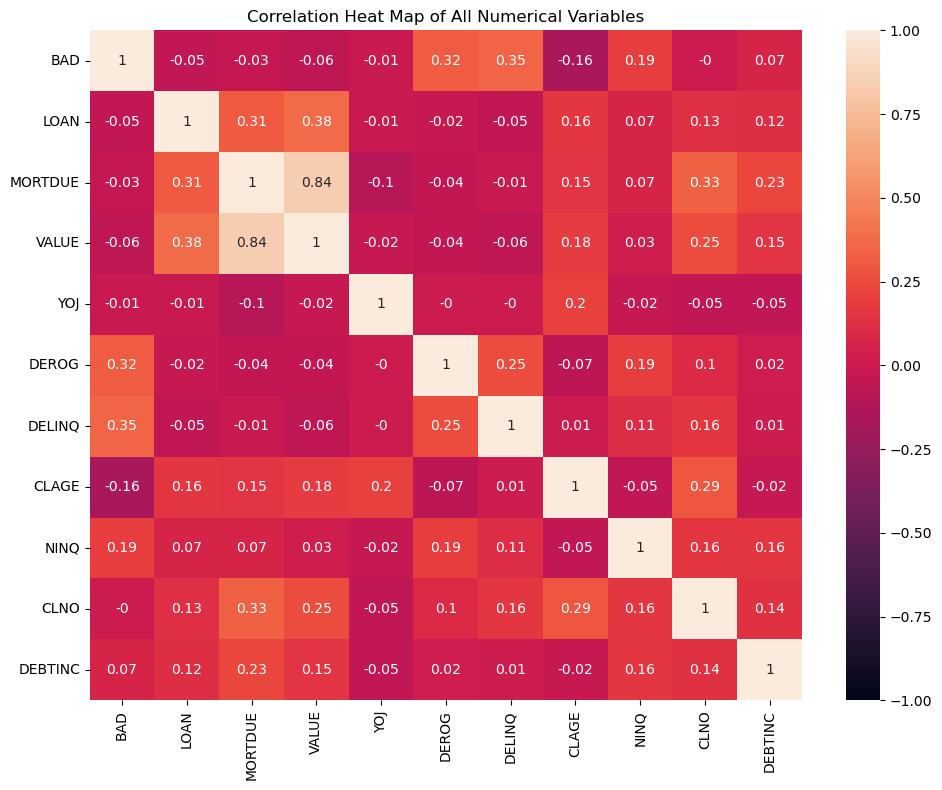

In [101]:
corr_matrix = np.round(loan.corr(), 2)

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True,  vmin=-1, vmax=1)

# Add titles and labels as needed
plt.title('Correlation Heat Map of All Numerical Variables')
plt.tight_layout() 

#### Observations
- The default status (BAD) is most strongly correlated with DEROG and DELINQ, highlighting the importance of credit history as a significant factor in assessing default risk.

- all in all, there are no strong correlations between BAD and other financial indicators such as  property value, or years at the job, indicating that no single financial metric is a strong predictor of loan default on its own.

#### What is the range of values for the loan amount variable "LOAN"?

In [102]:
loan.LOAN.min(),loan.LOAN.max()
print(f"The range of the amount of loan is ${loan.LOAN.max() - loan.LOAN.min()}") 

The range of the amount of loan is $39950


#### Multi-distribution 
- plot the distribution of multiple numerical variables

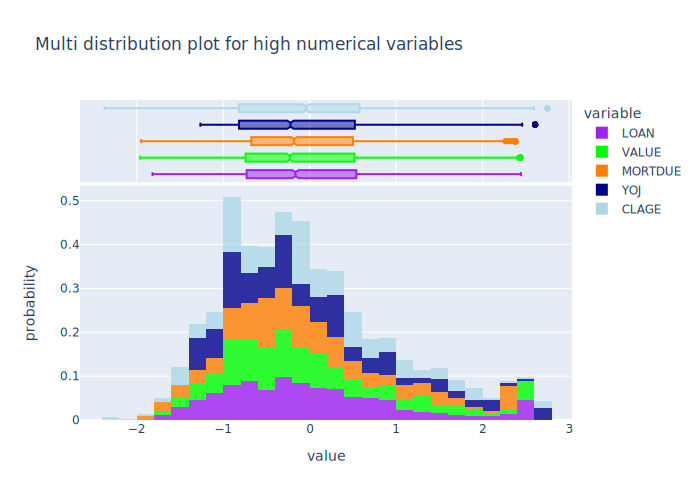

In [103]:
x_vars = ['LOAN', 'VALUE', 'MORTDUE', 'YOJ', 'CLAGE']

# normalize the variables because they're on different scales
loan_norm = (loan[x_vars] - loan[x_vars].mean()) / loan[x_vars].std()

px.histogram(loan_norm, x=x_vars,
             nbins=50, title='Multi distribution plot for high numerical variables',
             histnorm='probability', 
             opacity=0.8, marginal='box', 
             color_discrete_sequence=['#A020F0', '#00FF00', '#FF8000', '#00008B', '#ADD8E6'])

#### Normally distributed or not
-Let's find out the stats summary for these numerical variables to have a quick look at the numbers

In [104]:
def test_normality(data):
    normal_test_list = [
        ('LOAN', stats.normaltest(data['LOAN'])[1]),
        ('VALUE', stats.normaltest(data['VALUE'])[1]),
        ('MORTDUE', stats.normaltest(data['MORTDUE'])[1]),
        ('YOJ', stats.normaltest(data['YOJ'])[1]),
        ('CLAGE', stats.normaltest(data['CLAGE'])[1]),
        ('DEROG', stats.normaltest(data['DEROG'])[1]),
        ('DELINQ', stats.normaltest(data['DELINQ'])[1]),
        ('NINQ', stats.normaltest(data['NINQ'])[1]),
        ('CLNO', stats.normaltest(data['CLNO'])[1]),
        ('DEBTINC', stats.normaltest(data['DEBTINC'])[1])
    ]
    # loop for name of the variable and whether or not it's normal
    for var, pval in normal_test_list:
        if pval < 0.05:
            print(var, ": NOT normal")
        else:
            print(var, ": normal")
            
test_normality(loan)

LOAN : NOT normal
VALUE : NOT normal
MORTDUE : NOT normal
YOJ : NOT normal
CLAGE : NOT normal
DEROG : NOT normal
DELINQ : NOT normal
NINQ : NOT normal
CLNO : NOT normal
DEBTINC : NOT normal


#### Observations
- no numerical variables are normally distributed.

#### How many unique categories are there in the REASON variable?

In [105]:
loan.REASON.nunique()

2

#### Observation
- strange that there weren't more than 2 categories, or an 'Other' category as surely there must be more than 2 reasons to take out a loan

#### Loan amount based on default status
- is the amount significantly different?

In [106]:
default_loan = loan[loan['Status'] == 'Default']['LOAN']
good_loan = loan[loan['Status'] == 'Good']['LOAN']

np.round(default_loan.mean() - good_loan.mean())

-1119.0

#### Observation
- surprisingly, the average for defaulting loan amount is smaller than the good status loans by 1120 USD

#### Hypothesis Test with Mann-Whitney U
- Given that the LOAN variable is not normally distributed, we employ the Mann-Whitney U test to evaluate our hypothesis:

State the hypothesis:
* $H_0:$ The average approved loan amount for defaulting and good clients is statistically the same.
* $H_1:$ There is a statistically significant difference between the average approved loan amounts for clients who default and those who are in good standing.

In [107]:
# Since LOAN is not normally distributed, we have to use the mann-whitney U test
default_loan = loan[loan['Status'] == 'Default']['LOAN']
good_loan = loan[loan['Status'] == 'Good']['LOAN']

stat, p = stats.mannwhitneyu(default_loan, good_loan) # Conducting the test 
alpha = 0.05

if p < alpha:
    print('Sufficient evidence to reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

Sufficient evidence to reject the null hypothesis


#### Observation
- so even though it is only about 1.1k, it is a significant difference

#### What is the most common category in the JOB variable?

In [108]:
loan['JOB'].value_counts()

ProfExe    1252
Office      921
Mgr         746
Self        188
Sales       109
Name: JOB, dtype: int64

#### Observation
- Professional executive isn't very descriptive while sales probably means sales-professional either doing B2C or B2B, but that isn't clear either

#### Loan status vs. job fields

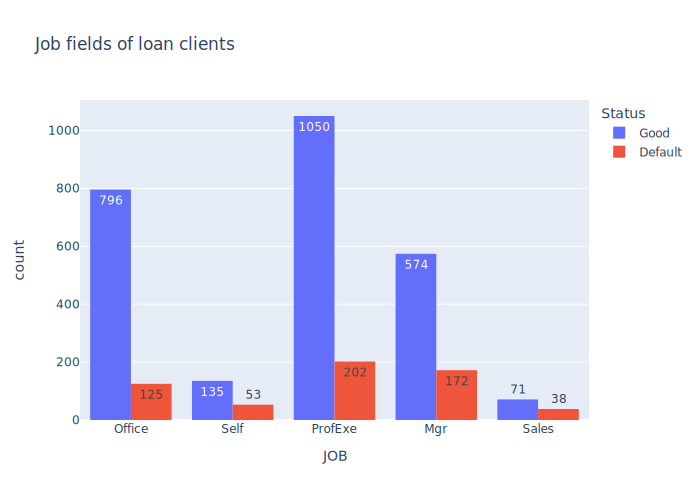

In [109]:
px.histogram(loan, x='JOB', title='Job fields of loan clients',
             color='Status', barmode='group',text_auto=True)

#### Observations
- In both good and default status, professional executives make up the largest portion but Office jobs make up the 2nd largest portion in good loans unlike in defaulting where Managers up the 2nd largest
- Self-employed is the least common job of clients who take out a loan

#### Reasons for loan
- Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?

Let's answer that with a chi-squared hypothesis test: 

State the hypothesis:
* $H_0:$ There is no relationship between the two Reasons and loan status.  
* $H_1:$ There is a statistically significant relationship between between the reasons for taking out a loan and whethere or not the loan will be paid off

alpha = 0.05

In [110]:
from scipy.stats import chi2_contingency

reason_status_cont = pd.crosstab(loan['Status'], loan['REASON'])

status_reason = chi2_contingency(reason_status_cont)[1]

if status_reason < 0.05:
    print('Evidence to reject the null hypothesis, there is a relationship between the two variables')
else:
    print('Evidence is not sufficient to reject the null, there is no significant relationship')

Evidence is not sufficient to reject the null, there is no significant relationship


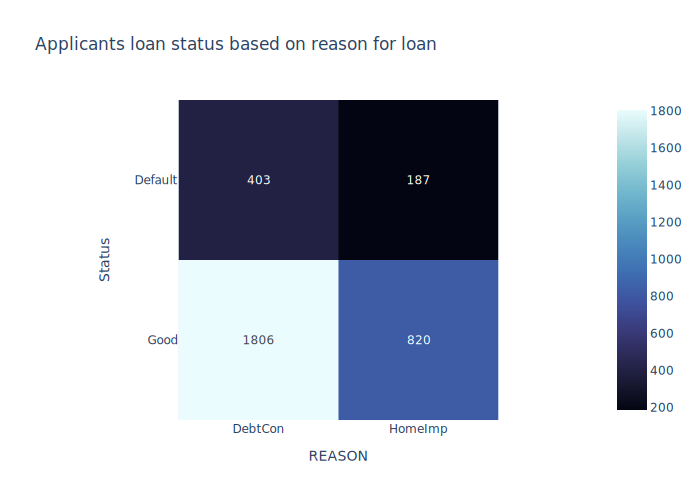

In [111]:
px.imshow(reason_status_cont,
             text_auto=True,color_continuous_scale='ice',
             title='Applicants loan status based on reason for loan')

#### Observation
- for both GL and DLs, the ratio of GL to DL is roughly the same at 4.48:1 for Debt consolidation, and 4.4:1 for homeimprovement
- compared to all categories, an overwhelming people take out a loan for debt consolidation and paid it off

#### Derogatory reports vs. status
- is there a significant difference in GL and DL's derogatory reports?

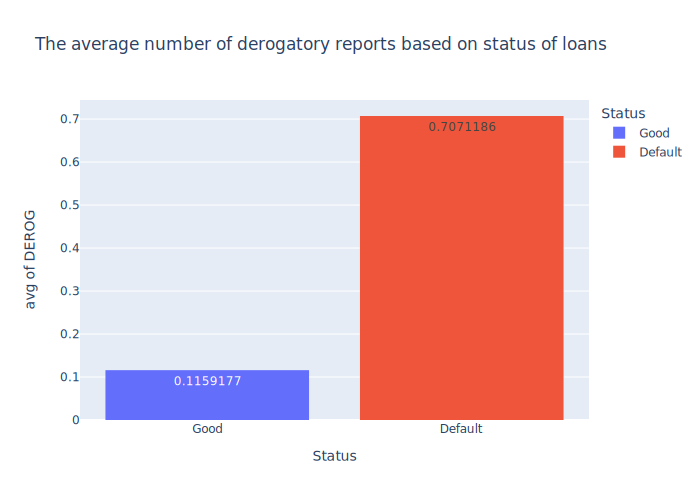

In [112]:
px.histogram(loan, x='Status', y='DEROG',
             color='Status', 
             histfunc='avg', 
             text_auto=True, title=
             'The average number of derogatory reports based on status of loans')

**Observations**
- quite an overwhelming difference in the average of GL at 0.08 and DL at 0.7 but the number is still less than 1.0

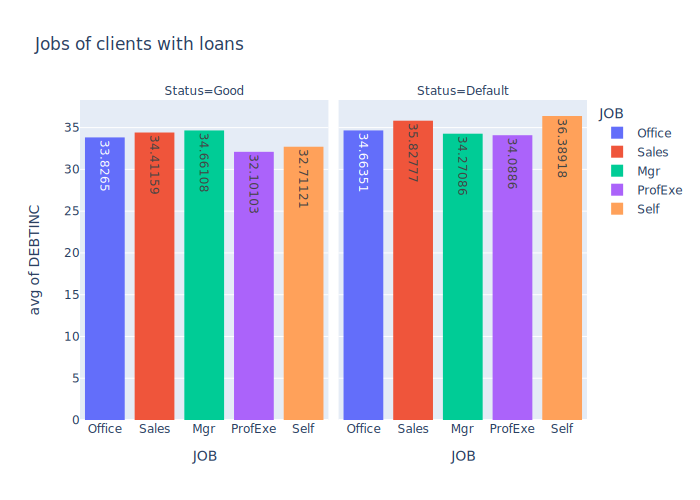

In [113]:
px.histogram(loan, title='Jobs of clients with loans', y='DEBTINC',
             x='JOB', histfunc='avg',color='JOB', facet_col="Status",
             text_auto=True)

#### Observation
- there doesn't seem to be any outliers or stark difference between the jobs and their average Debt to income ratio for both default and good status clients. 

#### Loan Amount vs. Debt to Income Ratio
-Using linear regression, let's analyze the relationship between the loan amount (LOAN) and the debt to income ratio (DEBTINC), considering loan status (BAD).

In [114]:
np.round(loan['DEBTINC'].describe().T,2)

count    3216.00
mean       33.52
std         6.81
min        13.68
25%        28.97
50%        34.40
75%        38.58
max        54.25
Name: DEBTINC, dtype: float64

In [115]:
X = sm.add_constant(loan['LOAN'])
y = loan['DEBTINC']
model = sm.OLS(y, X).fit()
loan['best_fit'] = model.predict(X)

print(f"The R^2 value is: {round(model.rsquared,3)}")

The R^2 value is: 0.014


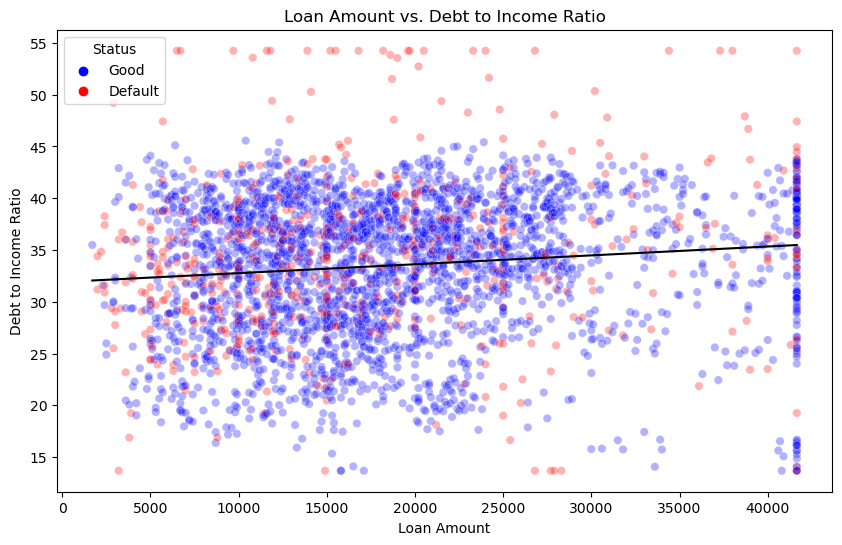

In [116]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=loan, x='LOAN', y='DEBTINC', hue='Status', alpha=0.3,
               palette={'Good':'blue','Default':'red'})

# Add the trend line
plt.plot(loan['LOAN'], loan['best_fit'], color='black')

# Set title and labels
plt.title('Loan Amount vs. Debt to Income Ratio')
plt.xlabel('Loan Amount')
plt.ylabel('Debt to Income Ratio')
plt.show()

#### Observation
-R-squared value of 0.013 indicates a very weak linear relationship. This value signifies that only 1.3% of the variance in the debt-to-income ratio is predictable from the loan amount, suggesting that LOAN is not a strong predictor of DEBTINC. 
-Interestingly, defaulted loans tend to have a higher debt-to-income ratio, pointing to other contributory factors to loan default.

## Insights and conclusions
##### Credit History Significance: 
- A borrower's credit history, including derogatory reports and delinquent credit lines, is a significant predictor of loan defaults.
##### Loan Reasons and Defaults: 
- The reason for a loan (debt consolidation vs. home improvement) shows a notable correlation with default rates.
##### Financial Metrics and Defaults: 
- Surprisingly, traditional financial metrics like loan amount and property value don't strongly correlate with default rates.

## Recommendations for future analysis
##### Job category granularity:
- A more detailed dataset with more categories for jobs
- more than just 2 categories for loan reasons
- a more detailed report of income could provide further insights
- Additional data points, such as credit-score could enhance the understanding of default risks.